#### What is Parallelization in LangGraph?
In LangGraph, nodes typically execute in a sequence defined by edges, but when tasks don’t depend on each other’s outputs, you can run them in parallel. This is achieved by:
- Defining multiple nodes that can operate independently.

- Connecting them to a common starting point (e.g., START or another node).

- Merging their outputs into a downstream node if needed.

LangGraph handles this implicitly when nodes are independent and can leverage multi-threading or asynchronous execution under the hood, depending on the runtime environment (e.g., Python’s asyncio or a multi-threaded executor).

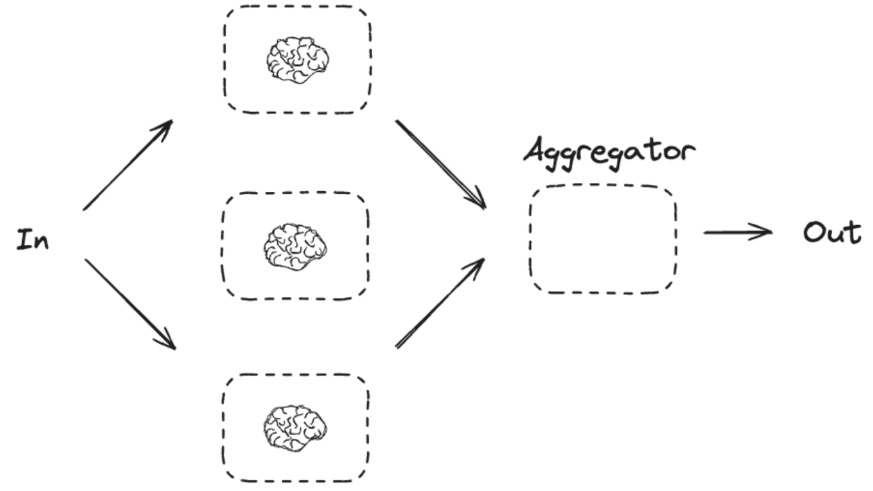

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm=ChatGroq(model="openai/gpt-oss-120b")
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'reasoning_content': 'The user just says "Hello". We respond politely.'}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 72, 'total_tokens': 102, 'completion_time': 0.06181224, 'prompt_time': 0.002858543, 'queue_time': 0.050417777, 'total_time': 0.064670783}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_70d048ba3c', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--d42483fa-9c8e-4cdc-88b2-c83b658a1347-0', usage_metadata={'input_tokens': 72, 'output_tokens': 30, 'total_tokens': 102})

In [2]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Graph state
class State(TypedDict):
    topic: str
    characters: str
    settings: str
    premises: str
    story_intro: str

In [3]:
# Nodes
def generate_characters(state: State):
    """Generate character descriptions"""
    msg = llm.invoke(f"Create two character names and brief traits for a story about {state['topic']}")
    return {"characters": msg.content}

def generate_setting(state: State):
    """Generate a story setting"""
    msg = llm.invoke(f"Describe a vivid setting for a story about {state['topic']}")
    return {"settings": msg.content}

def generate_premise(state: State):
    """Generate a story premise"""
    msg = llm.invoke(f"Write a one-sentence plot premise for a story about {state['topic']}")
    return {"premises": msg.content}

def combine_elements(state: State):
    """Combine characters, setting, and premise into an intro"""
    msg = llm.invoke(
        f"Write a short story introduction using these elements:\n"
        f"Characters: {state['characters']}\n"
        f"Setting: {state['settings']}\n"
        f"Premise: {state['premises']}"
    )
    return {"story_intro": msg.content}

In [4]:
# Build the graph
graph = StateGraph(State)
graph.add_node("character", generate_characters)
graph.add_node("setting", generate_setting)
graph.add_node("premise", generate_premise)
graph.add_node("combine", combine_elements)

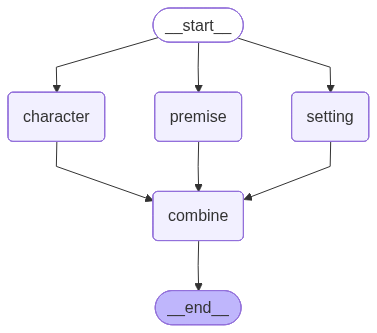

In [5]:
# Define edges (parallel execution from START)
graph.add_edge(START, "character")
graph.add_edge(START, "setting")
graph.add_edge(START, "premise")
graph.add_edge("character", "combine")
graph.add_edge("setting", "combine")
graph.add_edge("premise", "combine")
graph.add_edge("combine", END)

# Compile and run
compiled_graph = graph.compile()
graph_image = compiled_graph.get_graph().draw_mermaid_png()
display(Image(graph_image))

In [6]:
state = {"topic": "time travel"}
result = compiled_graph.invoke(state)
print(result["story_intro"])

**Chrono‑Harbor, Night‑Shift, 02:17 AM**

The fog rolled in thick as oil, swallowing the cracked dockboards and the low hum of the water’s metallic breath. From the gloom, the turquoise sheen of the harbor’s tide pulsed in slow, deliberate waves, each crest a thin ribbon of light that seemed to flicker forward and backward at once. Somewhere beyond the glass‑clad tower, a hover‑pod whispered past, leaving a ghostly trail of phosphorescent vapor that dissolved into the night like a sigh.

Dr. Selene Voss stood at the edge of the Victorian warehouse, her eyes narrowed behind the lenses of a chrono‑spectrometer she’d built herself. The brass gauges inside the boiler room clanged in a rhythm that matched the ticking of the pocket‑sized chronometer she kept in her coat pocket—a tiny, hand‑cranked device that, whenever she neared a temporal anomaly, began to tick **backward** with a soft, metallic click‑click. Tonight it was humming a frantic, reversed staccato, as if the very air around her

#### Key Benefits
- Speed: Reduces total execution time by running tasks concurrently.

- Scalability: Handles larger workflows efficiently.

- Modularity: Keeps the graph structure clean and reusable.

#### Key Takeaways
- When to Parallelize: Use it for independent tasks (e.g., generating multiple outputs, checking separate inputs).

- Merging: Downstream nodes can aggregate parallel results.

- LangGraph Support: The framework naturally supports this by waiting for all required inputs before proceeding.

